In [92]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [118]:
class CustomDigitsDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.targets = np.load(annotations_file)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'{idx}.npy')
        image = torch.FloatTensor(np.load(img_path))
        label = self.targets[idx]
        return image, label

In [119]:
data = CustomDigitsDataset('DIGITS_SYN_TARGET.npy','DIGITS_SYN/')

In [134]:
train_indices, test_indices, _, _ = train_test_split(range(len(data)), data.targets ,stratify=data.targets, test_size=0.1, random_state=42, shuffle=True)

train_split = Subset(data, train_indices)
test_split = Subset(data, test_indices)

train_loader = DataLoader(train_split, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_split, batch_size=len(test_split), shuffle=True)

In [129]:
class DiSyNet(torch.nn.Module):
    def __init__(self):
        super(DiSyNet, self).__init__()        

        activation_function  = torch.nn.Tanh()
        pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.conv1_2 = torch.nn.Conv2d(
            in_channels=6, out_channels=6, kernel_size=3, padding=1)
        
        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=16, out_channels=16, kernel_size=3, padding=0)

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(2912, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 20)
    
    def forward(self, x):

        x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        # print(x.size(1) * x.size(2) * x.size(3))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [135]:
def train(net, train_loader, test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)

    test_accuracy_history = []
    test_loss_history = []

    for X_test, y_test in test_loader:
        X_test = X_test.unsqueeze(1).to(device)
        y_test = y_test.to(device)

    for epoch in range(50):        
        for X_batch, y_batch in train_loader:
        
            optimizer.zero_grad()
            net.train()

            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        print(f'{epoch}/50: {accuracy}')


    return test_accuracy_history, test_loss_history


In [ ]:
net = DiSyNet()
accuracies, losses = train(net, train_loader, test_loader)

0/50: 0.8338888883590698
1/50: 0.8907407522201538
2/50: 0.9161111116409302
3/50: 0.9342592358589172
4/50: 0.9469135999679565
5/50: 0.9593827128410339
6/50: 0.9681481719017029
7/50: 0.9750617146492004
8/50: 0.9818518757820129
9/50: 0.9863580465316772
10/50: 0.987407386302948


In [139]:
plt.plot(losses)

In [ ]:
plt.plot(accuracies)

In [137]:
torch.save(net.state_dict(), './DySyNet_state_dict.pt')

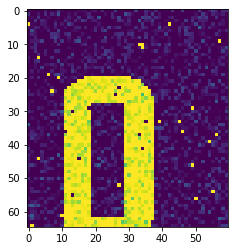

In [113]:
plt.imshow(X_test[0][0].cpu().detach().numpy())

Text(0.5, 1.0, '0')

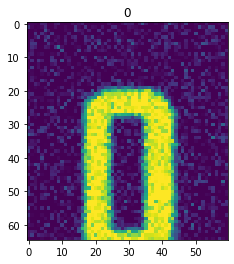

In [117]:
img = np.load('DIGITS_SYN/101.npy')
label = np.load('DIGITS_SYN_TARGET.npy')[3]
plt.imshow(img)
plt.title(label)
